<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03_Experiment_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Package

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-17 22:00:31.768474: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0217 22:00:31.768839 140202020403072 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0217 22:00:32.446733 140202020403072 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0217 22:00:33.511057 140202020403072 dataset_info.py:361] Load dataset info from /tmp/tmp26uy7ffptfds
I0217 22:00:33.513806 140202020403072 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0217 22:00:33.514433 140202020403072 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0217 22:00:34.284839 140202020403072 download_manager.py:476] 

In [37]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [38]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Encoder

In [4]:
def get_encoder(VOCAB_SIZE):
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
  encoder.adapt(train_dataset.map(lambda text, label: text))
  return encoder

### Create Model

In [21]:
def creat_model(encoder):
  model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
  ])
  return model

### Compile, Train Model

In [7]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [8]:
import datetime as dt

def compile_train_model(model, train_dataset, validation_dataset, test_dataset, epoch):
  #compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

### Explore Vocab

In [10]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

## Experiment A a

### Vocab 1000

In [9]:
VOCAB_SIZE = 1000
EPOCH_SIZE = 200
encoder1000 = get_encoder(VOCAB_SIZE)

In [11]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder1000)

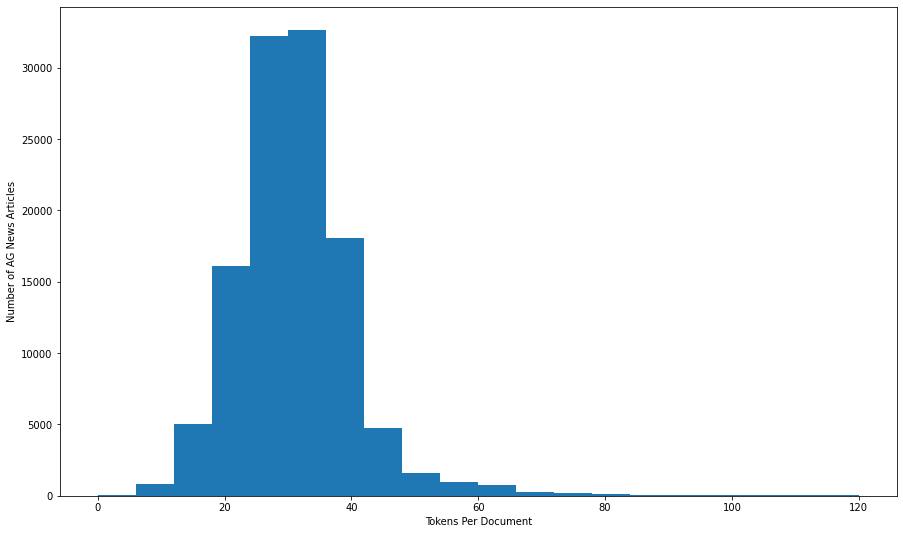

In [12]:
vocab = np.array(encoder1000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

119/119 [==============================] - 7s 59ms/step - loss: 0.4989 - accuracy: 0.8237
test set accuracy:  82.36842155456543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

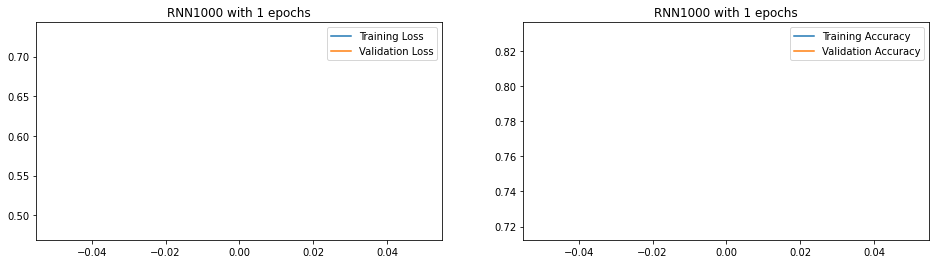

In [39]:
RNN1000 = creat_model(encoder1000)
result1000 = compile_train_model(RNN1000, 1)

In [40]:
result1000['vocab_size'] = VOCAB_SIZE 
result1000['num_words'] = num_words 
result1000['num_articles'] = num_articles
result1000['min_token_in_a_article'] = min_token_in_a_article 
result1000['max_token_in_a_article'] = max_token_in_a_article 

In [42]:
assignment_result_table = result1000
new_col = ['RNN with 1000 vocab size']   
assignment_result_table.insert(loc=0, column='Model', value=new_col)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words_in_corpus,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.730652,0.718079,0.481646,0.830667,0.498949,0.823684,279.930924,1,1,1000,1000,3492762,114000,3,168


### Vocab 2000

In [43]:
VOCAB_SIZE = 2000
EPOCH_SIZE = 200
encoder2000 = get_encoder(VOCAB_SIZE)

In [44]:
corpus2000, doc_sizes2000 = explore_vocab(train_dataset,encoder2000)

2000
114000
1782
16
64


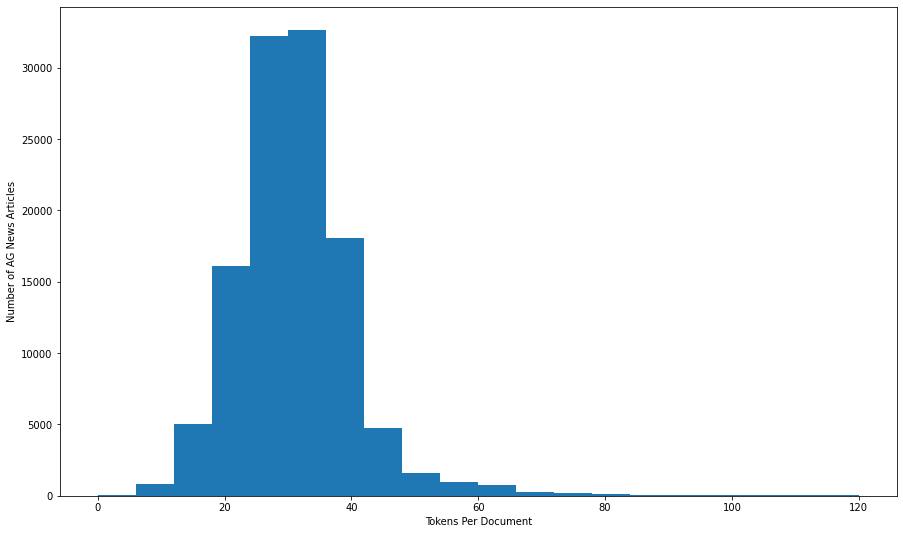

In [45]:
vocab2000 = np.array(encoder2000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab2000)

num_words =len(corpus2000)
num_articles =len(doc_sizes2000)
min_token_in_a_article = min(doc_sizes2000)
max_token_in_a_article = max(doc_sizes2000)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

119/119 [==============================] - 4s 37ms/step - loss: 0.4554 - accuracy: 0.8442
test set accuracy:  84.42105054855347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

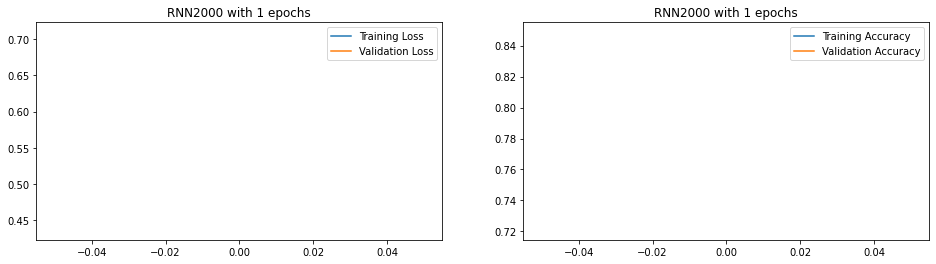

In [46]:
RNN2000 = creat_model(encoder2000)
result2000 = compile_train_model(RNN2000, 1)

In [47]:
result2000['vocab_size'] = VOCAB_SIZE 
result2000['num_words'] = num_words 
result2000['num_articles'] = num_articles
result2000['min_token_in_a_article'] = min_token_in_a_article 
result2000['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with 2000 vocab size']   
result2000.insert(loc=0, column='Model', value=new_col)

In [48]:
assignment_result_table = assignment_result_table.append(result2000, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words_in_corpus,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.730652,0.718079,0.481646,0.830667,0.498949,0.823684,279.930924,1,1,1000,1000.0,3492762,114000,3,168
1,RNN with 2000 vocab size,0.709644,0.720965,0.436728,0.848667,0.455375,0.844211,312.690750,1,1,2000,NaN,114000,1782,16,64


### Vocab 3000

In [49]:
VOCAB_SIZE = 3000
EPOCH_SIZE = 200
encoder3000 = get_encoder(VOCAB_SIZE)

In [50]:
corpus3000, doc_sizes3000 = explore_vocab(train_dataset,encoder3000)

3000
114000
1782
16
64


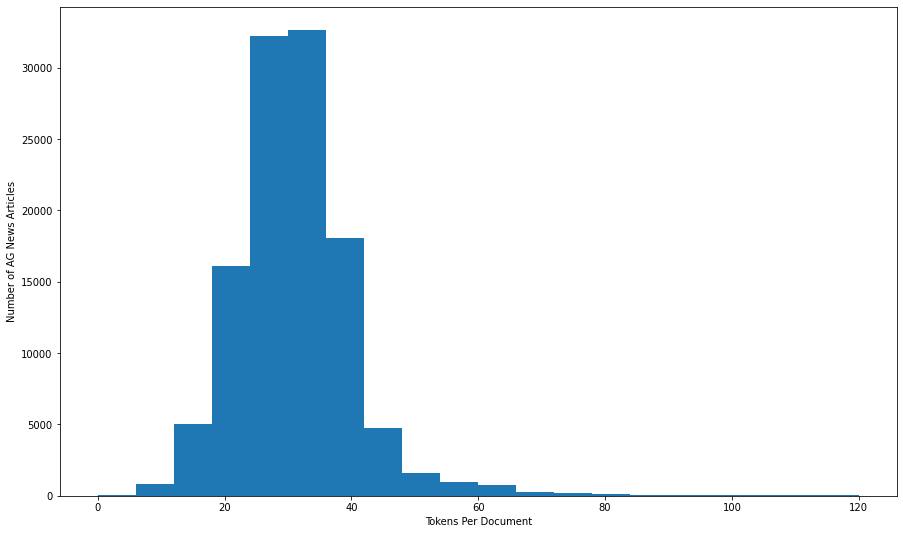

In [51]:
vocab3000 = np.array(encoder3000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab3000)

num_words =len(corpus3000)
num_articles =len(doc_sizes3000)
min_token_in_a_article = min(doc_sizes3000)
max_token_in_a_article = max(doc_sizes3000)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

119/119 [==============================] - 4s 37ms/step - loss: 0.4751 - accuracy: 0.8386
test set accuracy:  83.85526537895203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

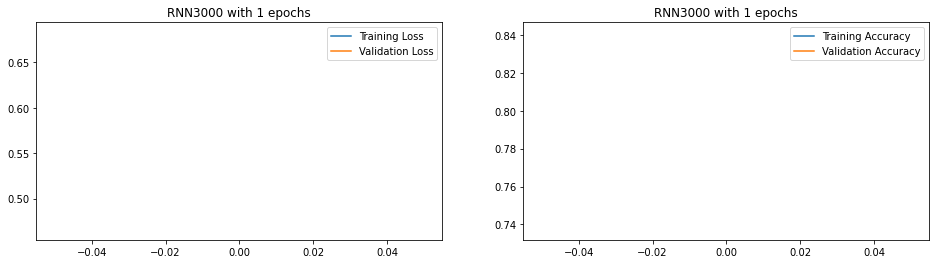

In [52]:
RNN3000 = creat_model(encoder3000)
result3000 = compile_train_model(RNN3000, 1)

In [53]:
result3000['vocab_size'] = VOCAB_SIZE 
result3000['num_words'] = num_words 
result3000['num_articles'] = num_articles
result3000['min_token_in_a_article'] = min_token_in_a_article 
result3000['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with 3000 vocab size']   
result3000.insert(loc=0, column='Model', value=new_col)

In [54]:
assignment_result_table = assignment_result_table.append(result3000, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words_in_corpus,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.730652,0.718079,0.481646,0.830667,0.498949,0.823684,279.930924,1,1,1000,1000.0,3492762,114000,3,168
1,RNN with 2000 vocab size,0.709644,0.720965,0.436728,0.848667,0.455375,0.844211,312.690750,1,1,2000,NaN,114000,1782,16,64
2,RNN with 3000 vocab size,0.683334,0.737070,0.465476,0.841500,0.475062,0.838553,274.739625,1,1,3000,NaN,114000,1782,16,64


### Plot Test Accuracy by Vocab Size

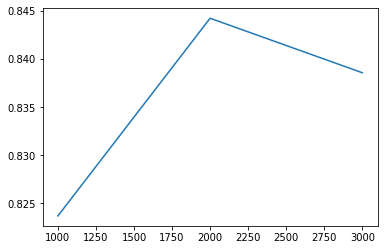

In [56]:
x= assignment_result_table['vocab_size']
y= assignment_result_table['test_accuracy']
plt.plot(x,y)

## Experiment A b
(b) Editing the Vocabulary: Try unedited most frequent words, VERSUS edit the list by deleting the most frequent words such as article, ‘the’, ‘a’, etc.

### Deleting the most frequent words from article

## Experiment A c
(c) Output sequence length: Use the default VERSUS set it to a fixed number

### Output sequence length

## Save data

In [ ]:
assignment_result_table.to_pickle("resultsAa.pkl") 

In [ ]:
prev_results_df = pd.read_pickle('resultsAa.pkl')
assignment_result_table = prev_results_df.append(assignment_result_table,ignore_index=True)
assignment_result_table